# Task 3 Classification
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to classify the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import cross_val_score, KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score, classification_report
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv("../dataset/user_indicators_uncorrelated.csv") 

In [3]:
dict_colors_bot = { 1: 'teal', 0: 'sandybrown'}

In [4]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['non-bot', 'bot']))

### Dataframe preprocessing

In [5]:
df.statuses_count = np.log(df.statuses_count + 1)
df.favorite_count_avg = np.log(df.favorite_count_avg  + 1)
df.favorite_count_sum = np.log(df.favorite_count_sum + 1)
df.retweet_count_sum = np.log(df.retweet_count_sum + 1)
df.reply_count_avg = np.log(df.reply_count_avg + 1)

Int64Index([1, 0], dtype='int64')


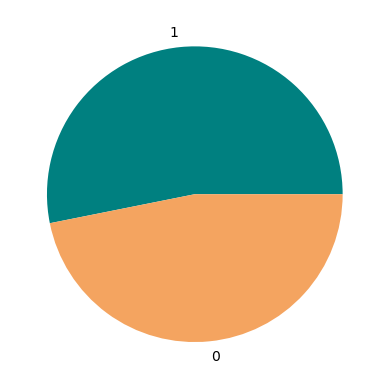

1    6116
0    5392
Name: bot, dtype: int64


In [6]:
bot_value_count = df['bot'].value_counts()
print(bot_value_count.keys())
# Show pie plot
labels = ['non-bot', 'bot']
plt.pie(bot_value_count, labels= bot_value_count.index, colors=[dict_colors_bot[v] for v in bot_value_count.keys()])
plt.show()
print(bot_value_count)

### Extract labels and data

Exclude some user specific features that are not useful or no to be used in clustering
(TODO: include lang?)

In [7]:
y = df['bot'].to_numpy()

cat_feature = df[['user_id', 'lang', 'created_at']]
del df['user_id']
del df['lang']
del df['created_at']
del df['bot']
df.head()

X = df.to_numpy()

Bot/non-bot ratio in whole dataset

# Train Test split

In [8]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=15, test_size=0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=15, test_size=0.18, stratify=y_dev)

In [9]:
print('Development set size:', len(y_dev), '- Bot ratio:', round(np.count_nonzero(y_dev)/len(y_dev), 2))
print('     Train set size:', len(y_train), '- Bot ratio:', round(np.count_nonzero(y_train)/len(y_train), 2))
print('     Validation set size:', len(y_val), '- Bot ratio:', round(np.count_nonzero(y_val)/len(y_val), 2))
print('Test set size:', len(y_test), '- Bot ratio:', round(np.count_nonzero(y_test)/len(y_test), 2))

Development set size: 9781 - Bot ratio: 0.53
     Train set size: 8020 - Bot ratio: 0.53
     Validation set size: 1761 - Bot ratio: 0.53
Test set size: 1727 - Bot ratio: 0.53


## Classification Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max.

We tried both normalizations to be used in subsequent clusterings.

In [10]:
scaler = MinMaxScaler()
X_minmax_dev = scaler.fit_transform(X_dev)
X_minmax_train = scaler.fit_transform(X_train)
X_minmax_val = scaler.fit_transform(X_val)
X_minmax_test = scaler.fit_transform(X_test)


In [11]:
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
k_list = [x for x in range(1, 20)]
knn_list = []
acc_tr_list = []
acc_val_list = []


for k in k_list:
    # Create knn model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_std_train, y_train)
    knn_list.append(knn)
    # Predict for train and validation sets
    y_pred_train = knn.predict(X_std_train)
    y_pred_val = knn.predict(X_std_val)
    # Accuracy
    acc_tr = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_val)

    #print('Accuracy train with k=', k, ':', acc_tr)
    #print('Accuracy validation with k=', k, ':', acc_val)

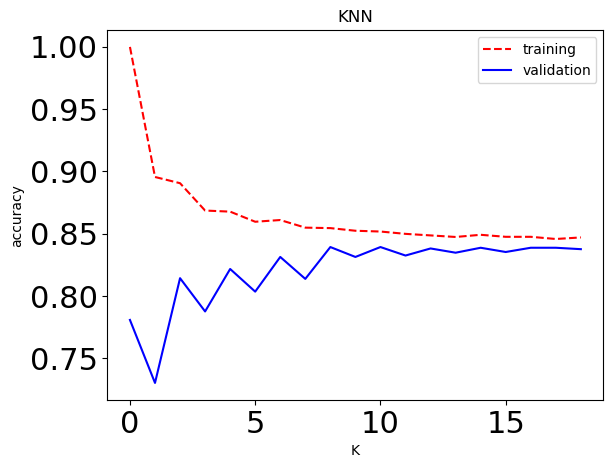

In [ ]:
plt.plot(range(len(acc_tr_list)), acc_tr_list, 'r--', label='training')
plt.plot(range(len(acc_val_list)), acc_val_list, 'b-',  label='validation')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('KNN')
plt.legend(loc="upper right")
plt.show()

We select K=10, as it is the smaller K where the model does not fall into overfitting.

In [ ]:
knn = knn_list[9]

y_pred_val = knn.predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

y_pred_test = knn.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Validation:
              precision    recall  f1-score   support

     non-bot       0.90      0.72      0.80       825
         bot       0.79      0.93      0.85       936

    accuracy                           0.83      1761
   macro avg       0.84      0.82      0.83      1761
weighted avg       0.84      0.83      0.83      1761

## Test:
              precision    recall  f1-score   support

     non-bot       0.87      0.72      0.79       809
         bot       0.79      0.90      0.84       918

    accuracy                           0.82      1727
   macro avg       0.83      0.81      0.82      1727
weighted avg       0.82      0.82      0.82      1727



Performances on test is very similar to validation. We have slightly lower recall for non-bots (0.72), meaning that there are a signinficant number of bots classified as 0.

# Bayesian classifier

In [26]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB 

In [27]:
gnb = GaussianNB()

y_pred_train = gnb.fit(X_std_dev, y_dev).predict(X_std_dev)
print('## Train:')
report_scores(y_dev, y_pred_train)

y_pred_test = gnb.fit(X_std_dev, y_dev).predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Train:
              precision    recall  f1-score   support

     non-bot       0.99      0.63      0.77      4583
         bot       0.75      0.99      0.86      5198

    accuracy                           0.82      9781
   macro avg       0.87      0.81      0.81      9781
weighted avg       0.86      0.82      0.82      9781

## Test:
              precision    recall  f1-score   support

     non-bot       0.47      1.00      0.64       809
         bot       0.00      0.00      0.00       918

    accuracy                           0.47      1727
   macro avg       0.23      0.50      0.32      1727
weighted avg       0.22      0.47      0.30      1727



c:\Users\alber\anaconda3\envs\dataMiningEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\anaconda3\envs\dataMiningEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\anaconda3\envs\dataMiningEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [28]:
bnb = BernoulliNB()

y_pred_train = bnb.fit(X_std_dev, y_dev).predict(X_std_dev)
print('## Train:')
report_scores(y_dev, y_pred_train)

y_pred_test = bnb.fit(X_std_dev, y_dev).predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Train:
              precision    recall  f1-score   support

     non-bot       0.77      0.63      0.69      4583
         bot       0.72      0.83      0.77      5198

    accuracy                           0.74      9781
   macro avg       0.74      0.73      0.73      9781
weighted avg       0.74      0.74      0.73      9781

## Test:
              precision    recall  f1-score   support

     non-bot       0.79      0.64      0.71       809
         bot       0.73      0.85      0.78       918

    accuracy                           0.75      1727
   macro avg       0.76      0.74      0.74      1727
weighted avg       0.76      0.75      0.75      1727



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
def build_decision_tree(X, y, cv=6, print_res=True):
    params = [{
    'criterion': ['gini', 'entropy'],
    #'max_depth': [5, 10, 20, None],
    'max_features': ['auto', 'log2'],
    #'min_samples_split': [2, 4, 6],
    #'min_samples_leaf': [2, 4]
    }] 
    clf = GridSearchCV(DecisionTreeClassifier(), params, refit = True, cv=cv, scoring='accuracy')
    clf.fit(X, y)
    if print_res:
        print("DT - Best parameters set found:")
        print(clf.best_params_)
        print("DT - Best accuraccy score found:")
        print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

In [37]:
best_score_dt, best_dt = build_decision_tree(X_std_dev, y_dev)

DT - Best parameters set found:
{'criterion': 'entropy', 'max_features': 'auto'}
DT - Best accuraccy score found:
0.7913296696545333


In [38]:
y_pred_test = best_dt.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.69      0.81      0.74       809
         bot       0.80      0.68      0.73       918

    accuracy                           0.74      1727
   macro avg       0.75      0.74      0.74      1727
weighted avg       0.75      0.74      0.74      1727



# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [37]:
def build_random_forest(X, y, cv=6, print_res=True):
    params = [{
    'max_depth': [20],
    'max_features': ['auto', 'log2'],
    #'min_samples_leaf': [1, 2], # da tunare
    #'n_estimators': [32, 64, 128]
    }] 
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy')
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
        print("RF - Best accuraccy score found:")
        print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

In [38]:
best_score_rf, best_rf = build_random_forest(X_std_dev, y_dev)

RF - Best parameters set found:
{'max_depth': 20, 'max_features': 'auto'}
RF - Best accuraccy score found:
0.8605458655723274


In [39]:
y_pred_test = best_rf.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.53      1.00      0.69       809
         bot       1.00      0.21      0.35       918

    accuracy                           0.58      1727
   macro avg       0.76      0.61      0.52      1727
weighted avg       0.78      0.58      0.51      1727



# SVM

In [ ]:
from sklearn import svm

In [47]:
def build_SVM(X, y, cv=6, print_res=True):
    params = [
    {"kernel": ["rbf"], "gamma": ["scale", "auto"], "C": [0.1, 10]},
    #{"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100, 300, 1000]},
    #{"kernel": ["poly"], "degree": [2,3,4], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100, 300, 1000]},

    ] 
    clf = GridSearchCV(svm.SVC(), params, refit = True, cv=cv, scoring='accuracy')
    clf.fit(X, y) #doppio refit?
    if print_res:
        print("SVM - Best parameters set found:")
        print(clf.best_params_)
        print("SVM - Best accuracy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [48]:
best_score_svm, best_svm = build_SVM(X_std_dev, y_dev)

SV M - Best parameters set found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.8410552414300908


In [49]:
y_pred_test = best_svm.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.97      0.70      0.81       809
         bot       0.79      0.98      0.87       918

    accuracy                           0.85      1727
   macro avg       0.88      0.84      0.84      1727
weighted avg       0.87      0.85      0.85      1727



# MLP